Implementing Portfolio Insurance (CCPI) and Drawdown Constraints

In [77]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import edhec_risk_kit as erk
import numpy as np
import pandas as pd

#Load the industry returns and the total market index we previously created

ind_return = erk.get_ind_returns()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
risky_r=ind_return["2000":][["Steel","Fin","Beer"]]
risky_r.shape

(228, 3)

In [7]:
safe_r=pd.DataFrame().reindex_like(risky_r)

In [8]:
safe_r.shape

(228, 3)

In [9]:
safe_r[:]=0.03/12
start=1000
floor=0.8

1. cushion= asset value-floorvalue
2. compute an allocation to safe and risky assets= m*risk_budget
3.Recompute the asset value based on the returns

In [10]:
def coumpound1(r):
    return(1+r).prod()-1

def coumpound2(r):
    return np.expm1(np.log1p(r).sum())


In [11]:
coumpound1(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [12]:
coumpound2(risky_r)

Steel   -0.051696
Fin      1.773937
Beer     3.361349
dtype: float64

In [13]:
%timeit coumpound1(risky_r)

1.66 ms ± 58 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%timeit coumpound2(risky_r)

495 µs ± 36.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
#Back to CPPI

In [15]:
dates=risky_r.index
n_steps=len(dates)
account_value=start
floor_value=start*floor
m = 3
account_history=pd.DataFrame().reindex_like(risky_r)
cushion_history=pd.DataFrame().reindex_like(risky_r)
risky_w_history=pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion=(account_value-floor_value)/account_value #my risk budget
    risky_w=cushion*m # how much money to allocate to the risky assets # no more than 100 because then we will leverage and we don't want that
    risky_w=np.minimum(risky_w,1) # not above 100
    risky_w=np.maximum(risky_w,0)# not bellow 0
    safe_w=1-risky_w 
    risky_allocation= account_value*risky_w
    safe_allocation=account_value*safe_w
    #update the account value
    account_value= risky_allocation*(1+risky_r.iloc[step])+ safe_allocation*(1+safe_r.iloc[step]) #iloc index when we have an integer
    #save the values so I can look at the history and plot it etc
    cushion_history.iloc[step]=cushion
    risky_w_history.iloc[step]=risky_w
    account_history.iloc[step]=account_value

In [16]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


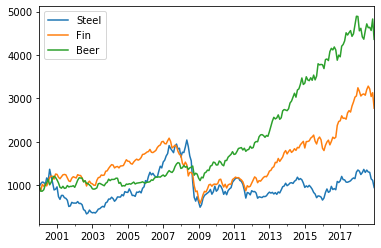

In [17]:
risky_wealth = start*(1+risky_r).cumprod() #what I would have gone if I invested in risky and did not do CPPI
risky_wealth.plot()

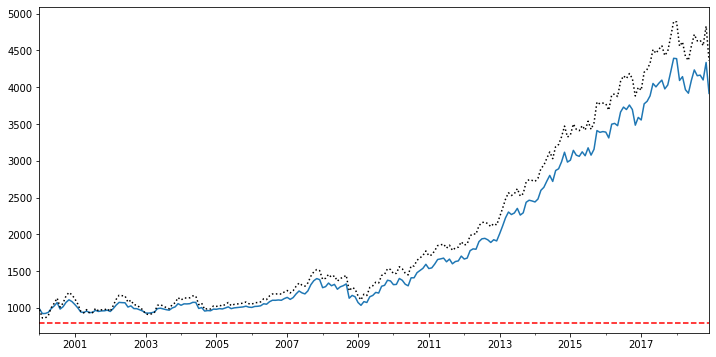

In [18]:
ax=account_history["Beer"].plot(figsize=(12,6))
risky_wealth["Beer"].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color='r', linestyle="--")

In [33]:
# blue line is CPPI accout hisory of beer. if i invester in beer alone i get 
#blue is dynamic mix of beer and safe asset

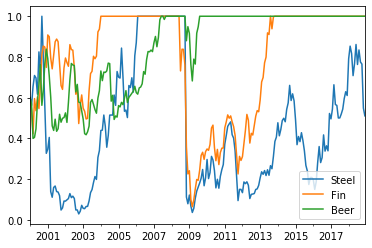

In [19]:
risky_w_history.plot()

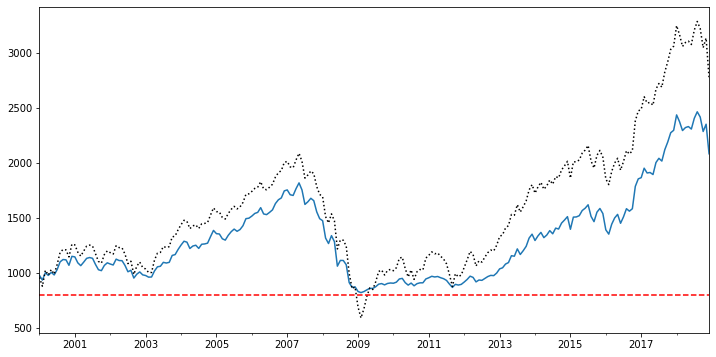

In [20]:
ind="Fin"
ax=account_history[ind].plot(figsize=(12,6))
risky_wealth[ind].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color='r', linestyle="--")

In [36]:
#using CPPI, finance sector nicey bouced off after the crash and did not get down the value floor but the opportunity cost of that 
#is that it did not take very much advantage from the recover

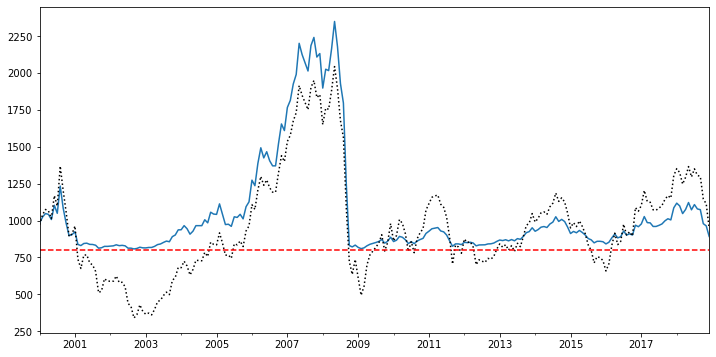

In [21]:
ind="Steel"
ax=account_history[ind].plot(figsize=(12,6))
risky_wealth[ind].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color='r', linestyle="--")

In [22]:
erk.summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-fisher Var(5%),Historic CVaR(5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368


In [23]:
btr=erk.run_cppi(risky_r) #back test result
erk.summary_stats(btr["Wealth"].pct_change().dropna()) #convert btr into 

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-fisher Var(5%),Historic CVaR(5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.130153,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.091621,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.074908,0.383772,-0.259582


In [31]:
# insurance meant to help you in the upside not the downside

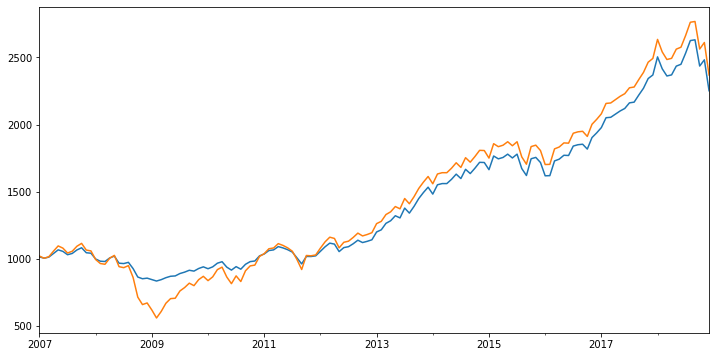

In [75]:
tmi_return=erk.get_tmi_rets()
btr=erk.run_cppi(tmi_return["2007":])
ax=btr["Wealth"].plot(figsize=(12,6), legend=False)
btr["Risky Wealth"].plot(ax=ax, legend=False)

In [82]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-fisher Var(5%),Historic CVaR(5%),Sharpe Ratio,Max Drawdown
R,0.073411,0.150463,-0.734939,4.523488,0.071592,0.096315,0.280618,-0.499943


In [84]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-fisher Var(5%),Historic CVaR(5%),Sharpe Ratio,Max Drawdown
R,0.069416,0.100381,-0.588292,3.740932,0.045678,0.062953,0.382052,-0.229683


In [85]:
#Drawdown constraint 

In [86]:
btr=erk.run_cppi(ind_return["2007":][["Steel","Fin", "Beer"]], drawdown=0.25)

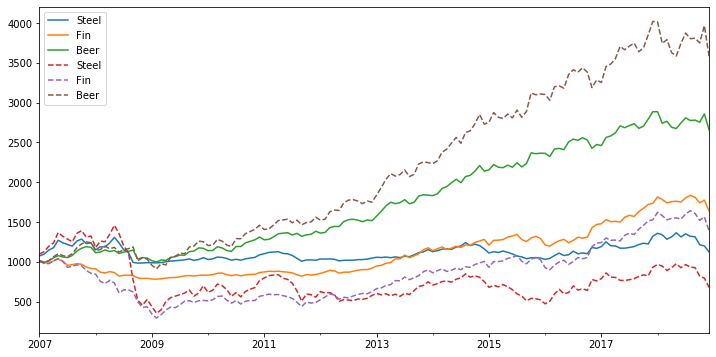

In [87]:
ax=btr["Wealth"].plot(figsize=(12,6))
btr["Risky Wealth"].plot(ax=ax, style="--")



In [89]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-fisher Var(5%),Historic CVaR(5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


In [90]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-fisher Var(5%),Historic CVaR(5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.441089,5.220481,0.047371,0.066991,-0.262958,-0.248059
Fin,0.041975,0.085028,-0.355163,4.153860,0.038342,0.054111,0.136964,-0.243626
Beer,0.084375,0.086263,-0.744111,4.571533,0.037937,0.051189,0.613413,-0.161186
